<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Create-and-train-model" data-toc-modified-id="Create-and-train-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create and train model</a></span><ul class="toc-item"><li><span><a href="#Make-model" data-toc-modified-id="Make-model-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Make model</a></span></li><li><span><a href="#Train-nets" data-toc-modified-id="Train-nets-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Train nets</a></span></li></ul></li><li><span><a href="#Load-and-analysis-of-saved-trained-nets" data-toc-modified-id="Load-and-analysis-of-saved-trained-nets-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load and analysis of saved trained nets</a></span><ul class="toc-item"><li><span><a href="#See-final-parameters-for-different-pre-trained-nets" data-toc-modified-id="See-final-parameters-for-different-pre-trained-nets-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>See final parameters for different pre-trained nets</a></span></li><li><span><a href="#See-parameter-history-for-single-pre-trained-nets" data-toc-modified-id="See-parameter-history-for-single-pre-trained-nets-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>See parameter history for single pre-trained nets</a></span></li><li><span><a href="#Study-spectrum-of-trained-networks" data-toc-modified-id="Study-spectrum-of-trained-networks-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Study spectrum of trained networks</a></span></li></ul></li><li><span><a href="#Plots-used-in-paper" data-toc-modified-id="Plots-used-in-paper-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plots used in paper</a></span></li></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import glob
from IPython.display import display
from IPython.core.debugger import set_trace
from collections import OrderedDict
import itertools
import os
import sys
import pickle
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sympy
import pandas as pd

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

import cufflinks

import qutip
import theano
import theano.tensor as T

src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

import qubit_network.net_analysis_tools as nat
import qubit_network.utils
from qubit_network.utils import chop, complex2bigreal, bigreal2complex, bigreal2qobj
from qubit_network.QubitNetwork import pauli_product
from qubit_network.model import QubitNetworkGateModel
from qubit_network.Optimizer import Optimizer
from qubit_network.net_analysis_tools import NetDataFile, NetsDataFolder

# Create and train model

## Make model

Create `qutip` object for "double fredkin" gate. This is a 4-qubit gate acting as a Fredkin if the first qubit is $\lvert0\rangle$, and as a Fredkin with inverse control if the first qubit is $\lvert1\rangle$.
In other words, the gate swaps the third and fourth qubit if the first two qubit are either $\lvert01\rangle$ or $\lvert10\rangle$.

<IPython.core.display.Javascript object>


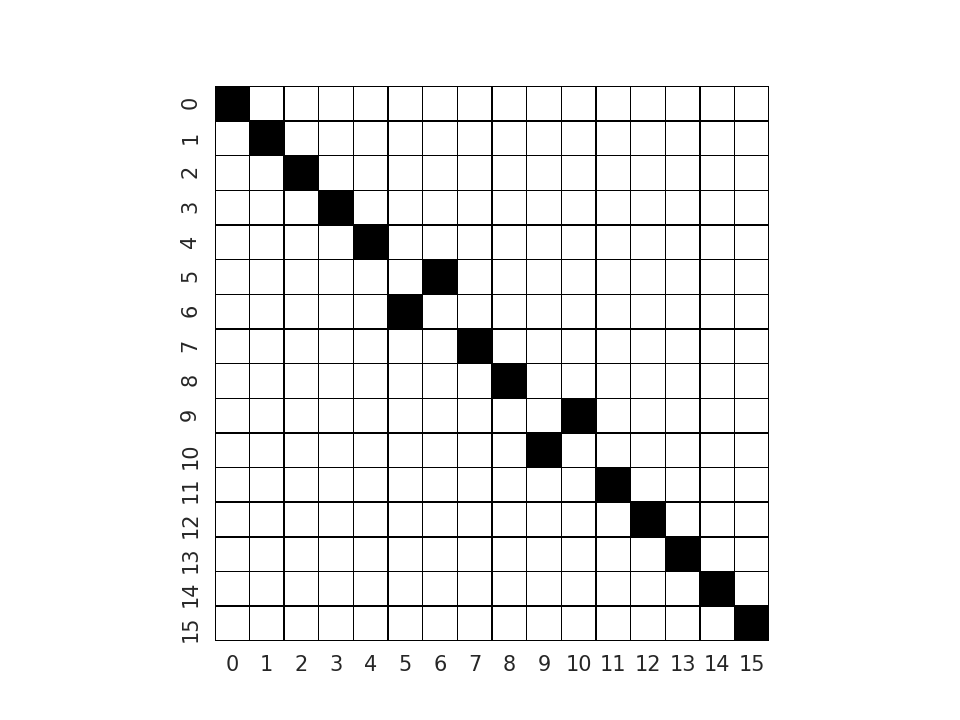

In [2]:
antifredkin = qutip.tensor(qutip.projection(2, 0, 0), qutip.swap())
antifredkin += qutip.tensor(qutip.projection(2, 1, 1), qutip.qeye([2, 2]))
antifredkin
ff = qutip.tensor(qutip.projection(2, 0, 0), qutip.fredkin())
ff += qutip.tensor(qutip.projection(2, 1, 1), antifredkin)

sns.set_style('dark')
sns.heatmap(ff.full().real, square=True, cbar=False, linewidths=.2, linecolor='Black', cmap='Greys');

Generate symbolic expression of the Hamiltonian containing only two-qubit interactions commuting with the above double Fredkin

In [3]:
from qubit_network.analytical_conditions import commuting_generator
sympy.init_printing()
ff_diagonal = commuting_generator(ff, interactions='diagonal')
ff_diagonal

⎡2.0⋅J₀₀₃₀ + 1.0⋅J₀₀₃₃ + 1.0⋅J₀₃₀₀ + 2.0⋅J₀₃₃₀ + 1.0⋅J₃₀₀₀ + 2.0⋅J₃₀₀₃ + 1.0⋅J
⎢                                                                             
⎢                             1.0⋅ⅈ⋅J₀₀₀₂ + 1.0⋅J₀₀₁₀                         
⎢                                                                             
⎢                             1.0⋅ⅈ⋅J₀₀₀₂ + 1.0⋅J₀₀₁₀                         
⎢                                                                             
⎢                              1.0⋅J₀₀₁₁ - 1.0⋅J₀₀₂₂                          
⎢                                                                             
⎢                                        0                                    
⎢                                                                             
⎢                              1.0⋅J₀₁₁₀ - 1.0⋅J₀₂₂₀                          
⎢                                                                             
⎢                              1.0⋅J₀₁₁₀ - 1.0⋅J₀₂₂₀

## Train nets

Compiling model ... done.


<IPython.core.display.Javascript object>


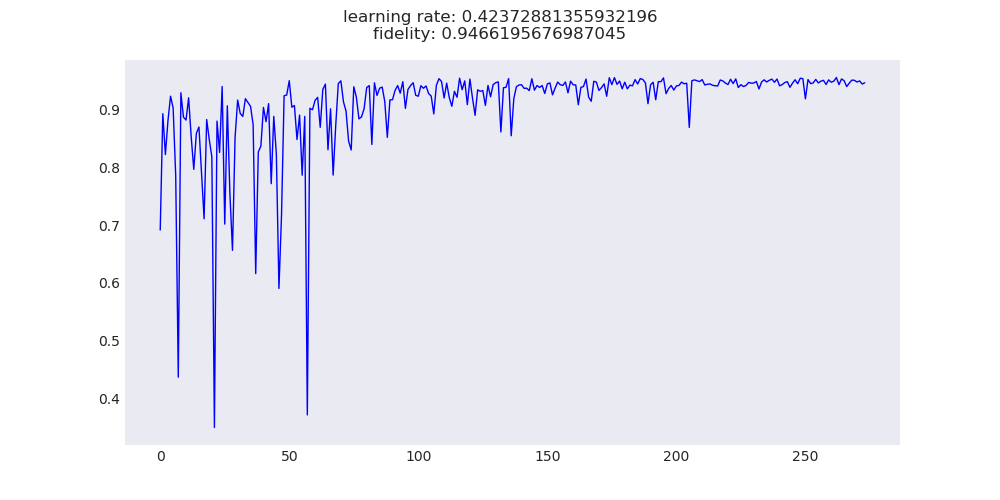

In [4]:
net = QubitNetworkGateModel(sympy_expr=ff_diagonal, initial_values=4)
optimizer = Optimizer(
    net=net,
    learning_rate=1,
    decay_rate=.005,
    n_epochs=400,
    batch_size=2,
    target_gate=ff,
    training_dataset_size=200,
    test_dataset_size=100,
    sgd_method='momentum'
)
optimizer.run()
# optimizer.save_results('../data/new_nets/doublefredkin_diagonal(4).pickle')

# Load and analysis of saved trained nets

## See final parameters for different pre-trained nets

In [7]:
NetsDataFolder('../data/new_nets/').filter('doublefredkin_diagonal_initvalues4*').plot_parameters(hlines=[])

In [8]:
NetsDataFolder('../data/new_nets/').filter('doublefredkin_diagonal_initvalues10*').plot_parameters(hlines=[])

## See parameter history for single pre-trained nets

In [18]:
Optimizer.load('../data/new_nets/doublefredkin_diagonal(3).pickle').plot_parameters_history()

Double check that the resulting gates are what they are supposed to be

In [34]:
NetsDataFolder('../data/new_nets/').filter('fredkin*')[0]

,target gates,names
0,fredkin,fredkin_diagonal(01)
1,fredkin,fredkin_diagonal(02)
2,fredkin,fredkin_diagonal(03)
3,fredkin,fredkin_diagonal(04)
4,fredkin,fredkin_diagonal(05)
5,fredkin,fredkin_diagonal(06)
6,fredkin,fredkin_diagonal(07)
7,fredkin,fredkin_diagonal(08)
8,fredkin,fredkin_diagonal(09)
9,fredkin,fredkin_diagonal(10)


## Study spectrum of trained networks

[-1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


<IPython.core.display.Javascript object>


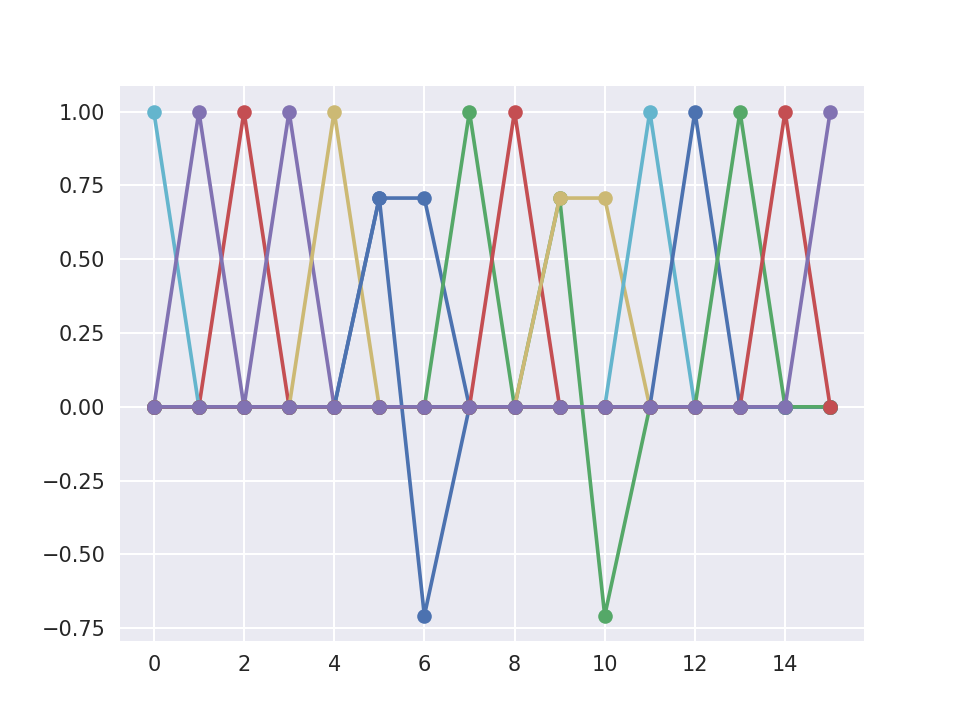

In [28]:
print(scipy.linalg.eigvalsh(ff.full()))
plt.plot(np.arange(16), scipy.linalg.eigh(ff.full())[1].real, 'o-');

As expected, there are exactly two eigenvalues there are odd multiples of $\pi$, 

In [22]:
datafile = NetsDataFolder('../data/new_nets/').filter('doublefredkin*')[0]
H = datafile.data.get_current_hamiltonian()

gate = chop(qutip.Qobj(scipy.linalg.expm(-1j * H)))
phase = np.angle(gate[0, 0])
np.sort(chop(scipy.linalg.eigvals(H) + phase).real / np.pi)

array([-26., -19., -18., -16., -12.,  -8.,  -7.,  -6.,   0.,   0.,   4.,
         6.,  12.,  20.,  28.,  36.])

<IPython.core.display.Javascript object>


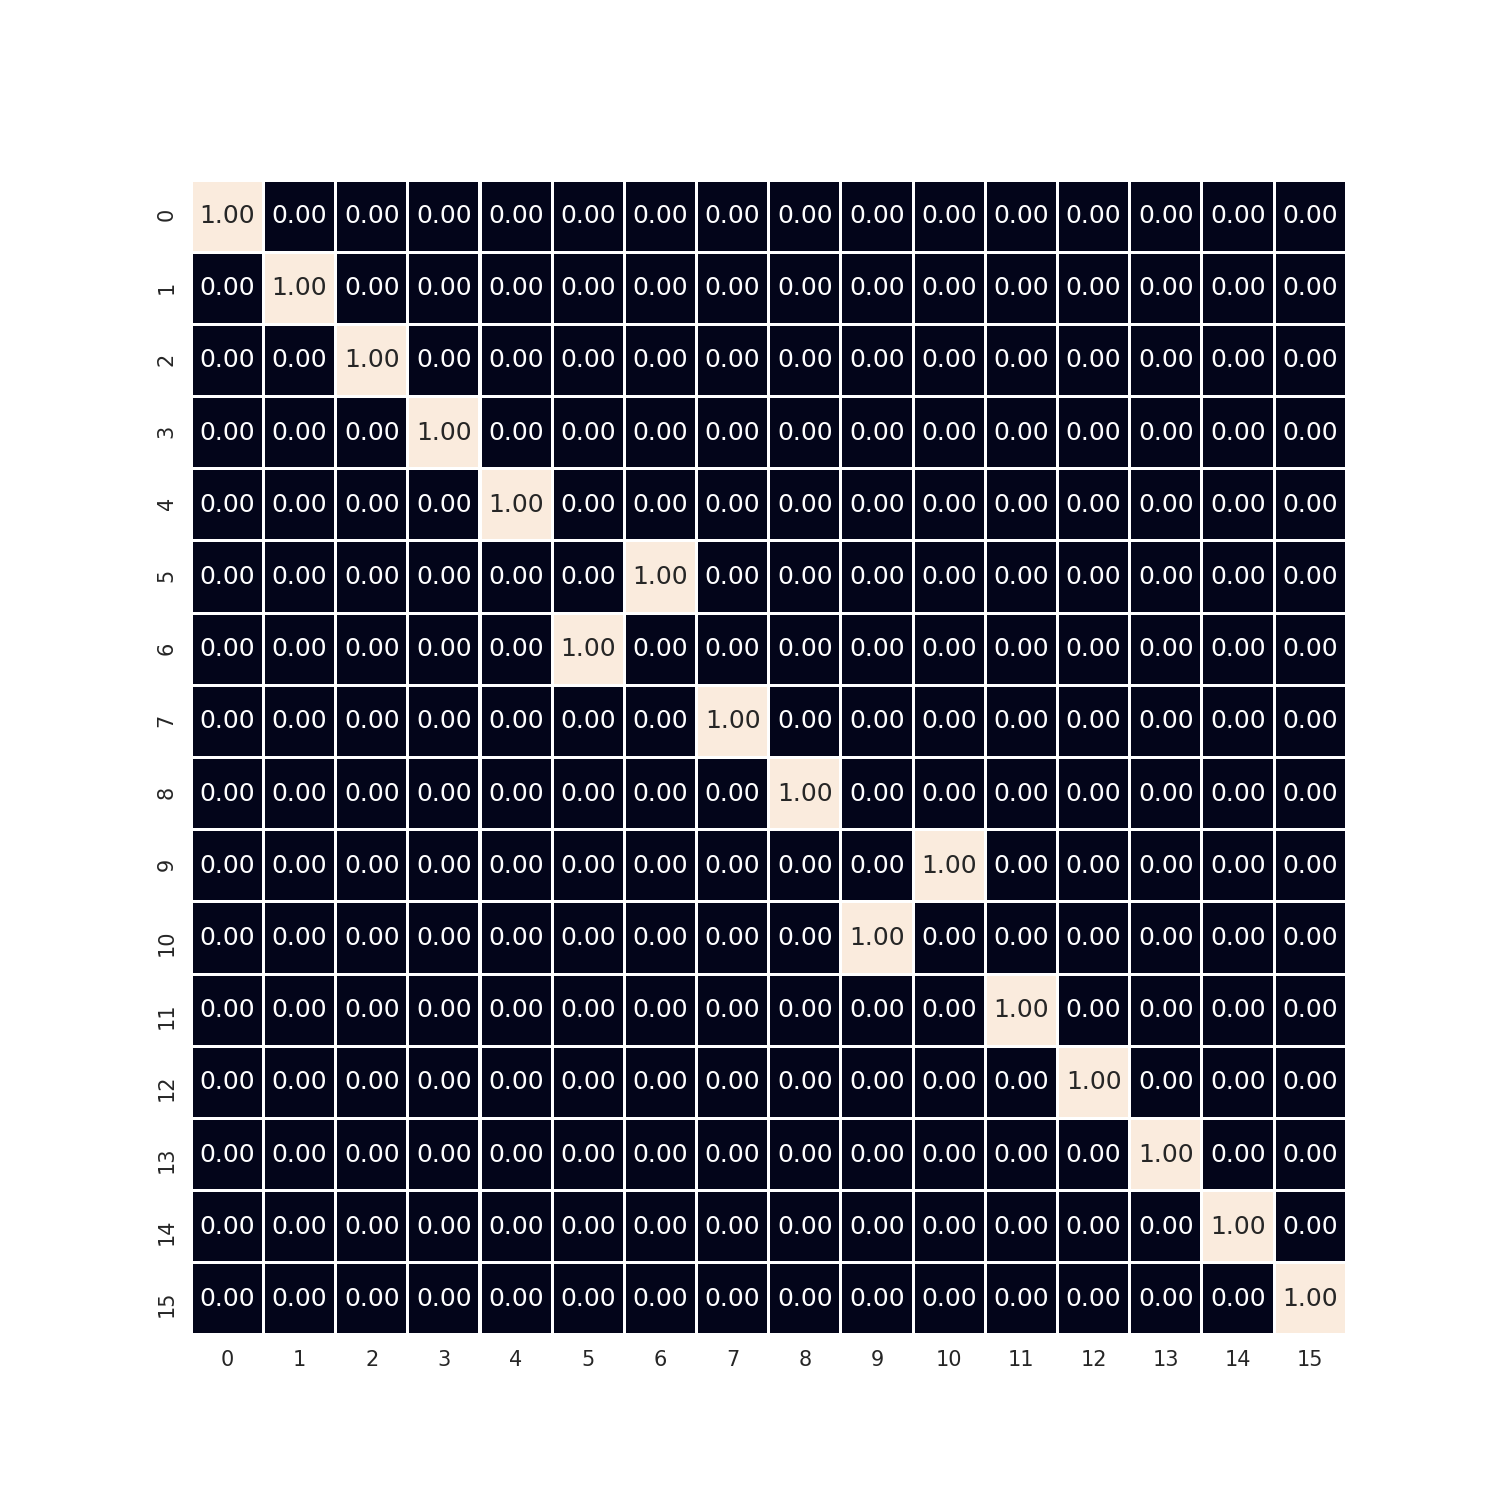

In [24]:
nat.plot_gate(NetsDataFolder('../data/new_nets/').filter('doublefredkin*')[0])

In [148]:
NetsDataFolder('../data/new_nets/').filter('doublefredkin_diagonal_initvalues4*')[0].fidelity_test(10000)

1.0

# Plots used in paper

<IPython.core.display.Javascript object>


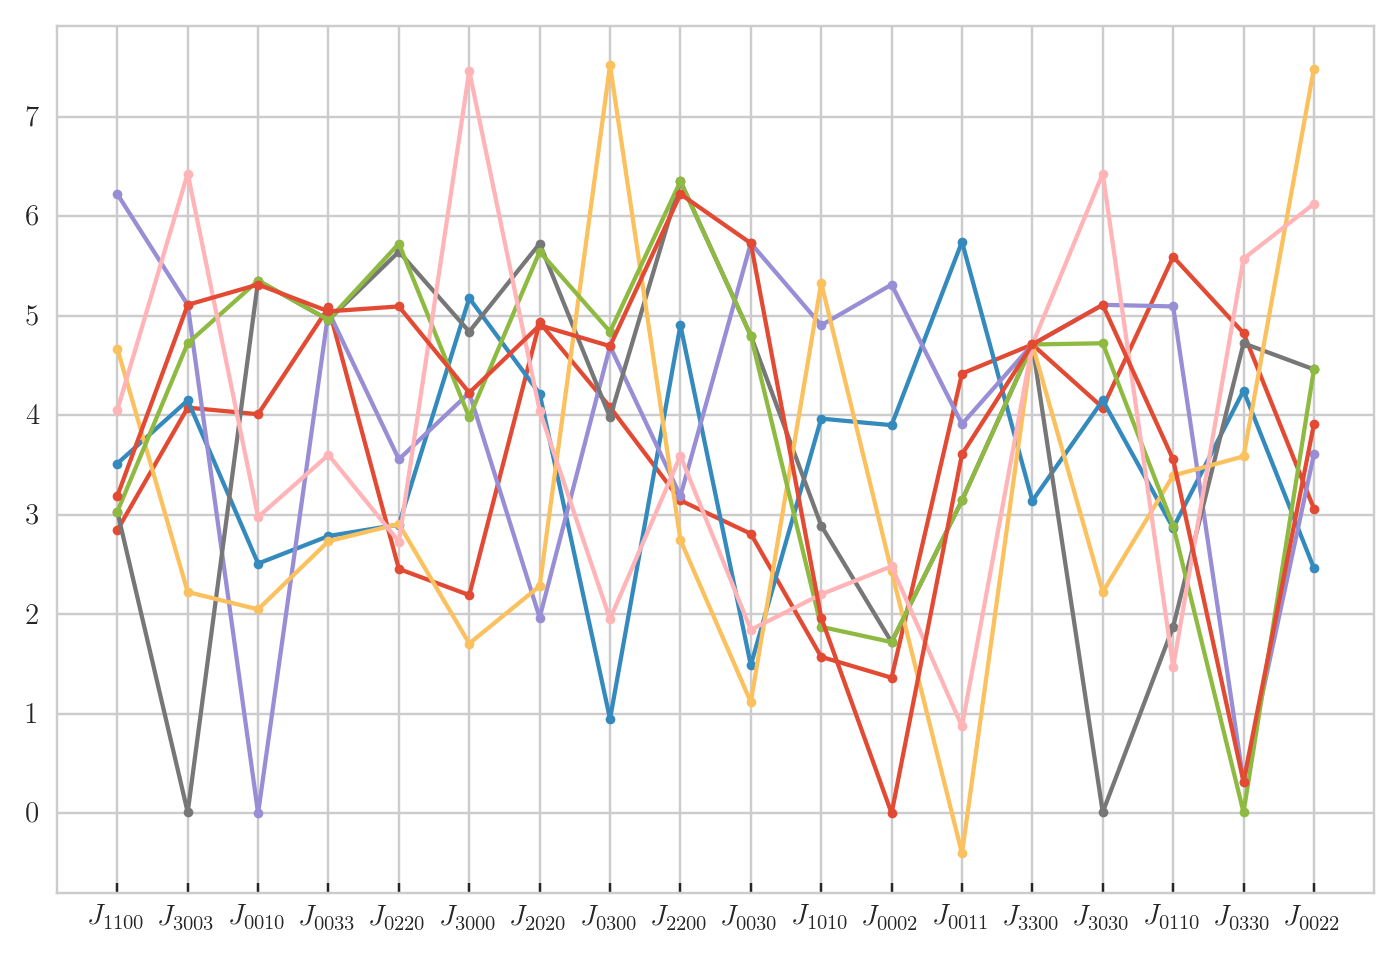

In [144]:
plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig, ax = plt.subplots(1, 1)

ndf = NetsDataFolder('../data/new_nets/').filter('doublefredkin_diagonal_initvalues4*')[[0, 1, 2, 4, 5, 6, 7, 8]]
df = ndf.view_parameters().sort_index(axis=1)
df.index = df.index.map(str)
# df.T.reset_index(drop=True).plot(ax=ax, marker='o', markersize=4., legend=False)
df.plot(ax=ax, marker='o', markersize=4, legend=False)
# ax.set_title('Different solutions for Toffoli with diagonal interactions', fontsize=16)
# ax.set_xlabel('Parameters', fontsize=14)
ax.set_xlabel('')
# ax.set_ylabel('Values', fontsize=14)
# change font size of tick labels
ax.tick_params(axis='both', labelsize=12)
ax.tick_params(axis='x', length=4, direction='in')
# better range
# ax.set_xlim(-0.1 , 8.1)
# mathify xaxis labels
ax.set_xticks(range(df.shape[0]))
xlabels = list(df.index.get_values())
def adjust_xlabel(text):
    return '$' + text[0] + '_{' + text[1:] + '}$'
ax.set_xticklabels([adjust_xlabel(label) for label in xlabels])
# fix sizes
plt.tight_layout()
# save to file
# fig.savefig('doublefredkin_diagonal_initvalues4_8samples.pdf', bbox_inches='tight')